# **C like Code generation with LSTM**

In this project we are aiming to produce code which looks like any generic C like program. We know that text is sequential data, i.e. the next character depends on the previous character. As a result we choose one of the many Recurrent cells available in the **tensorflow.keras** module - The LSTM cell.

We are going for basic character level text generation. As this level of text generation works better for body of text with less number of different words. C like programs do not have many words when it comes in comparison to texts like novels or poems or other literary data.


Let us start by first importing the libraries and taking a look at the data.

In [0]:
from __future__ import print_function
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
from keras.optimizers import RMSprop, Adam
from keras.utils.data_utils import get_file
import numpy as np
import matplotlib.pyplot as plt
import random
import sys
import io

Now we are going to open our text file, it is UTF-8 encoded. From this file we are going to get our text corpus (body of text). We then find every new character and add it to a list. This list is going to be out character dictionary. 

The model will get the index of the characters in the character dictionary as an input and it will predict the index of the character which is going to be followed. We thus convert the characters to integers for the model for an easy representation.

In [80]:
with io.open("/content/final.txt", encoding='utf-8') as f:
    text = f.read().lower()
print('corpus length:', len(text))

chars = sorted(list(set(text)))
print('total chars:', len(chars))
char_indices = dict((c, i) for i, c in enumerate(chars))
indices_char = dict((i, c) for i, c in enumerate(chars))

corpus length: 319705
total chars: 70


**Now we need to vectorize the input and the output.**

We start by splitting the text into random segments of a selected maximum length. After we have retrived the sentence we will store the character next to the sentence as the target chracter.

Keeping this is mind:
1.   The indexes of the characters from the sentences turn into our input vector.
2.   The (index of the) character next to our sentence becomes our target y.



In [81]:
# cut the text in semi-redundant sequences of maxlen characters
maxlen = 50
step = 4
sentences = []
next_chars = []

for i in range(0, len(text) - maxlen, step):
    sentences.append(text[i: i + maxlen])
    next_chars.append(text[i + maxlen])
print('Number of sequences:', len(sentences))

print('Vectorization')
x = np.zeros((len(sentences), maxlen, len(chars)), dtype=np.bool)
y = np.zeros((len(sentences), len(chars)), dtype=np.bool)
for i, sentence in enumerate(sentences):
    for t, char in enumerate(sentence):
        x[i, t, char_indices[char]] = 1
    y[i, char_indices[next_chars[i]]] = 1
print("Done")

Number of sequences: 79914
Vectorization
Done


***LSTMs - A brief.***

Recurrent Neural Networks work just fine when we are dealing with short-term dependencies. However, vanilla RNNs fail to understand the context behind an input. The reason behind this is the problem of **Vanishing Gradient**.

*What is the vanishing graident problem ?*

> As more layers using certain activation functions are added to neural networks, the gradients of the loss function approaches zero, making the network hard to train. For shallow network with only a few layers that use these activations, this isn’t a big problem. However, when more layers are used, it can cause the gradient to be too small for training to work effectively.

As a solution to this problem of Vanilla RNNs, LSTM was proposed in 1997 by [Sepp Hochreiter and Jürgen Schmidhuber](http://www.bioinf.jku.at/publications/older/2604.pdf). A common LSTM unit is composed of a cell, an input gate, an output gate and a forget gate. The cell remembers values over arbitrary time intervals and the three gates regulate the flow of information into and out of the cell.

Intuitively, the cell is responsible for keeping track of the dependencies between the elements in the input sequence. The input gate controls the extent to which a new value flows into the cell, the forget gate controls the extent to which a value remains in the cell and the output gate controls the extent to which the value in the cell is used to compute the output activation of the LSTM unit. 


![Basic Structure of LSTM cell - Image from Wikipedia](https://upload.wikimedia.org/wikipedia/commons/3/3b/The_LSTM_cell.png)



Now comes the most important part of our endeavour. Creating the Neural Network Model which can learn (or atleast fake) writing a C like program segment.

Things to keep in mind:
1.   The model consists of two main layers - The LSTM Layer and The Dense connected layer.
2.   The LSTM layer gets the vectorized character inputs from the character dictionary and has 128 units.
3.   The LSTM layer has an 'ReLU' activation which stands for rectified linear unit and is used to break symmetry in the initial layer of the model.
4.   The Dense layer has a softmax output. The softmax activation produces probabilities for the index as output.

The Model has been complied with RMSprop optimizer which a standard speedup for gradient descent, and categorical_crossentropy loss which is used when we need to predict probabilites for various categories (in this case the categories are the characters).



In [82]:
# build the model: a single LSTM
print('Building model')
model = Sequential()
model.add(LSTM(64, input_shape=(maxlen, len(chars))))
model.add(Dense(len(chars), activation='softmax'))

optimizer = RMSprop(lr=0.01)
model.compile(loss='categorical_crossentropy', optimizer=optimizer)
model.summary()

Building model
Model: "sequential_9"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
lstm_9 (LSTM)                (None, 64)                34560     
_________________________________________________________________
dense_9 (Dense)              (None, 70)                4550      
Total params: 39,110
Trainable params: 39,110
Non-trainable params: 0
_________________________________________________________________


**Let us see how the model looks like.**

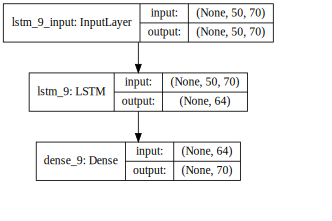

In [83]:
from IPython.display import SVG
from keras.utils import model_to_dot

SVG(model_to_dot(model, show_shapes=True, dpi=60).create(prog='dot', format='svg'))

**Now we train our model.**

We use the fit() function which takes care of our training. The parameters x and y are the input and corresponding output vectors.

Hyperparamters:

1.   Batch size = 128
2.   Epochs = 50

The training history has been saved in a History.history object.

In [84]:
history = model.fit(x, y, batch_size=128, epochs=50, verbose = 0)
print("Training Done.")

Training Done.


Now plotting the **loss graph** for the model.

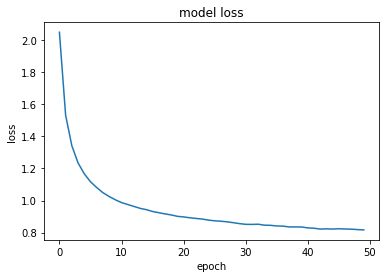

In [85]:
plt.plot(history.history['loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.show()

Now we generate output using standard **temperature sampling** which is suggested for NLP projects. The temperature paramater decides the diversity of the sampling. The high temperature sample displays greater linguistic variety, but the low temperature sample is more grammatically correct. Lowering the temperature allows you to focus on higher probability output sequences and smooth over deficiencies of the model. The helper function to sample an index from a probability array.

The custom_pred function can be given a C-Like code which it can use as the seed for generating sentences which are supposed to look like C code.

In [0]:
def sample(preds, temperature=1.0):
    preds = np.asarray(preds).astype('float64')
    preds = np.log(preds) / temperature
    exp_preds = np.exp(preds)
    preds = exp_preds / np.sum(exp_preds)
    probas = np.random.multinomial(1, preds, 1)
    return np.argmax(probas)

def custom_pred(s = ""):
    start_index = random.randint(0, len(text) - maxlen - 1)
    for diversity in [0.2, 0.5, 1.0, 1.2]:
        print('Diversity:', diversity,"\n")

        generated = ''
        sentence = text[start_index: start_index + maxlen]
        if len(s) != 0:
            sentence = s
        else:
            sentence = text[start_index: start_index + maxlen]
        generated += sentence
        print('Generating with seed: "' + sentence + '"'+"\n")
        sys.stdout.write(generated)

        for i in range(400):
            x_pred = np.zeros((1, maxlen, len(chars)))
            for t, char in enumerate(sentence):
                x_pred[0, t, char_indices[char]] = 1.

            preds = model.predict(x_pred, verbose=0)[0]
            next_index = sample(preds, diversity)
            next_char = indices_char[next_index]

            sentence = sentence[1:] + next_char

            sys.stdout.write(next_char)
            sys.stdout.flush()
        print()

The following line is a call to the custom_pred function which generates C like code.

Moment of truth!

In [87]:
custom_pred()

Diversity: 0.2 

Generating with seed: "y *free;
    sdl_syswmentry *wmmsg_used;
    sdl_s"

y *free;
    sdl_syswmentry *wmmsg_used;
    sdl_syswmevent(event);
    sdl_syswmevent(event, size_t chunk_olus, sdl_strclllock_tromevents * sdl_strlen;
    sdl_event_watchers_lock);
    sdl_strlen(m, sdl_touch->couse_watchers[i].dollarte(sdl_strled.hersize);
                                                                                                                                                                                              
Diversity: 0.5 

Generating with seed: "y *free;
    sdl_syswmentry *wmmsg_used;
    sdl_s"

y *free;
    sdl_syswmentry *wmmsg_used;
    sdl_syswmeventche(sdl_windowevent_cos(userdagn);
                            assert(int * = (size_t);
                                                                                                                                                                                                                        

Well, that does look like C code. However under no circumstances can this code be complied. It is beautiful work around for writing C code. However this projects has huge grounds for improvement.

Although we can note that with increasing diversity the code gets more unreadable or starts making lesser sense. However we have completed our objective of producing C like code using Keras and a dataset of C programs.

Made by:

*   Shayak Chakraborty
*   Jayanta Banik
*   Shubham Addhya

**END OF NOTEBOOK**